## 1. Importing Dependencies

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])
import scipy as sp
from scipy.integrate import odeint

In [55]:
def plot_predicted_and_actual(x_actual_data,x_pred_data):
		dt = 0.05
		timeaxis = np.arange(0, (x_actual_data.shape[0])*dt, dt)

		# Plot data on each subplot
		plt.figure(figsize=(15,3))	
		plt.plot(timeaxis, x_actual_data.T[0], label="x1",color="orange",lw=1.1)
		plt.plot(timeaxis, x_pred_data.T[0], label="x1_pred",ls="--" , color='blue', lw=1.1)  
		plt.plot(timeaxis, x_actual_data.T[1],color="orange",lw=1.1)
		plt.plot(timeaxis, x_pred_data.T[1],ls="--" , color='blue', lw=1.1)   
		plt.ylabel("r(t)")
		plt.xlabel("t")
		plt.ylim(-0.1,1)
		plt.title("Comparison of the Predicted and Actual Data")
		plt.legend(loc='upper right')
		plt.show()

## 3. Obtaining Data

The equation we are working with is

$$\dot{x} = -x + \frac{k_1}{2}x(x-x^2) + \frac{k_2}{2}x^2(x-x^3)$$

In [56]:
def dxdt(t, x, k_1, k_2):
    return -x + (k_1/2) * (x - x**3) + (k_2/2) * (x**3 - x**5)

where we have $k_2 = 8$

### 3.2 Time series for different $K_1$ values

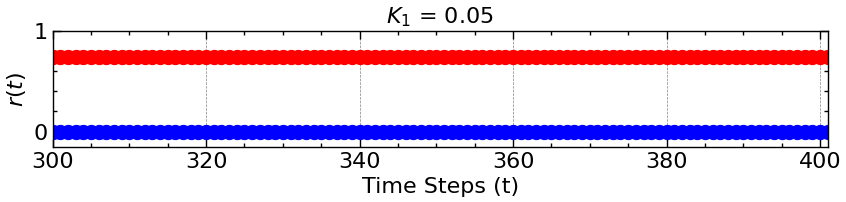

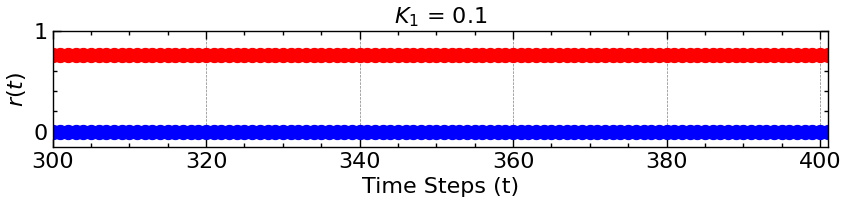

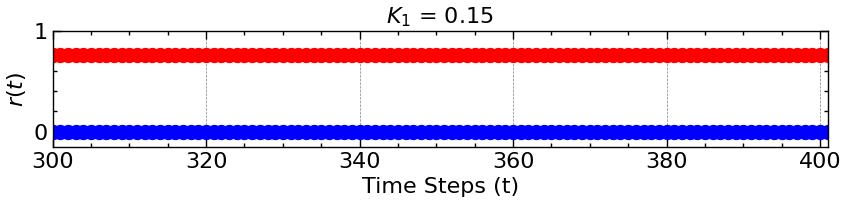

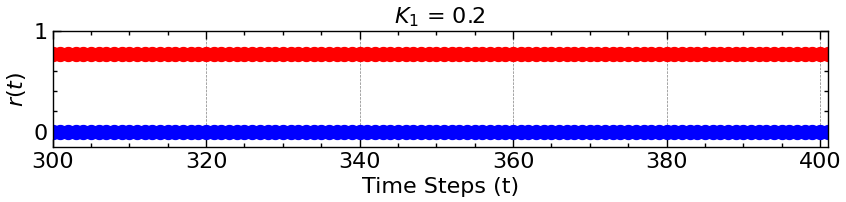

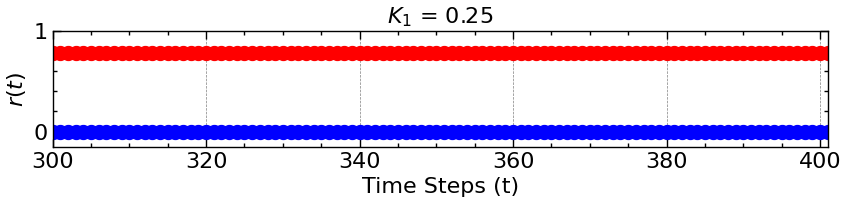

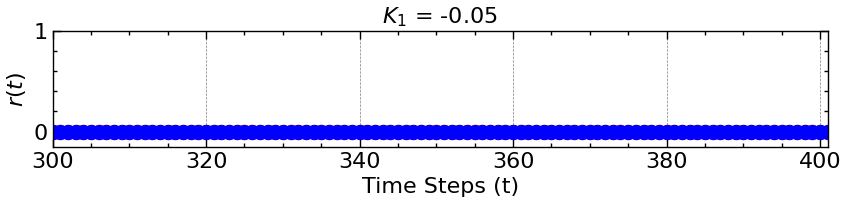

In [57]:
k_1_values = [0.05,0.1,0.15,0.2,0.25,-0.05]
k2 = 8

dt = 0.05
timesteps = 36000
t = np.linspace(0, timesteps * dt, timesteps)

for k1 in k_1_values:
    x_up_data = odeint(dxdt, y0=0.7, t=t,args=(k1,k2), tfirst=True)
    x_down_data = odeint(dxdt, y0=0.2, t=t,args=(k1,k2), tfirst=True)
    r_up_data = np.array(x_up_data)
    r_down_data = np.array(x_down_data)
    plt.figure(figsize=(10, 1.5))
    plt.plot(r_up_data, marker="o", color = "red")
    plt.plot(r_down_data, marker="o", color = "blue")
    plt.title(r"$K_1$ = {}".format(k1))
    plt.xlabel("Time Steps (t)")
    plt.ylabel(r"$r(t)$")
    plt.xlim(300, 401)
    plt.ylim(-0.15,1)
    plt.grid(True)
    plt.show()


### 3.3 Obtaining data and making training and testing split

In [58]:
def solution_for_para(k1,k2):
    y0_values = [0.7, 0.2]
    solutions = [odeint(dxdt, y0=y0, t=t, args=(k1, k2), tfirst=True) for y0 in y0_values]
    x_data = np.hstack(solutions)  
    return x_data

In [59]:
k_1_values = [0.05,0.1,0.15,0.2,0.25,-0.05]
k2 = 8
data_x_list = []
dt = 0.05
timesteps = 36000
t = np.linspace(0, timesteps * dt, timesteps)

for k1 in k_1_values:
    x_data = solution_for_para(k1,k2) 
    data_x_list.append(x_data)

stacked_x = np.transpose(np.vstack(data_x_list))   
stacked_total = np.squeeze(stacked_x)
print(stacked_total.shape)

(2, 216000)


In [60]:
from PaResPy import ReservoirComputer as PARC

training_data,valid_data,train_without_transient = PARC.train_test_split(stacked_total)

 The training data shape : (80000, 2)
 The testing data shape : (16000, 2)


In [61]:
dim_system = 2
alpha = 1
dim_reservoir, rho, sigma, k_b =  [150, 0.4, 0.01632776502336586, 0.04]
model = PARC(dim_system, dim_reservoir, rho, sigma, k_b, alpha)  
eps_train = [0.05,0.1,0.15,0.2,0.25]
model.train(training_data, train_without_transient,eps_train)

# 5. Prediction for different k1 values

(16000, 2)
The NRMSE value of mu value -0.1 : 1.0000681118555068


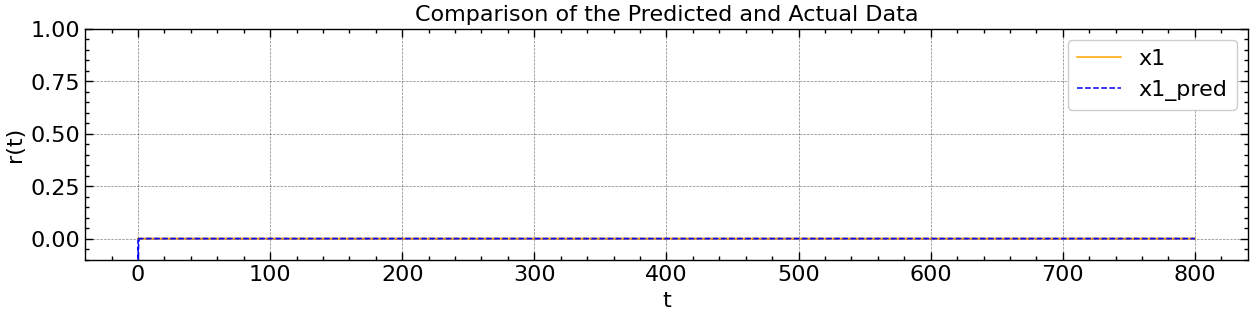

(16000, 2)
The NRMSE value of mu value -0.05 : 1.0001176596673578


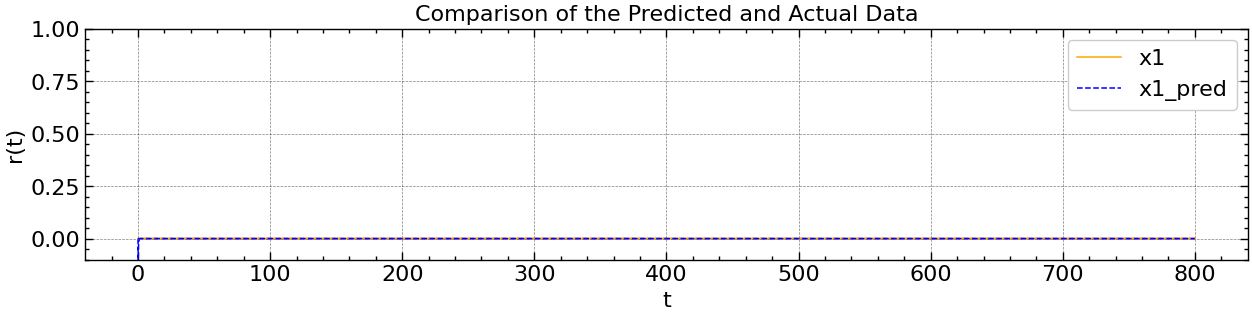

(16000, 2)
The NRMSE value of mu value 0.13 : 2.6313935855725014e-05


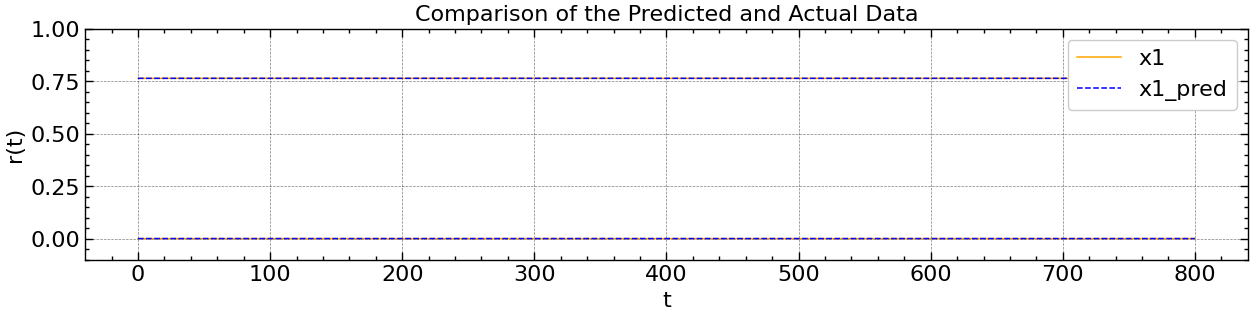

(16000, 2)
The NRMSE value of mu value 0.23 : 1.2064344462477132e-05


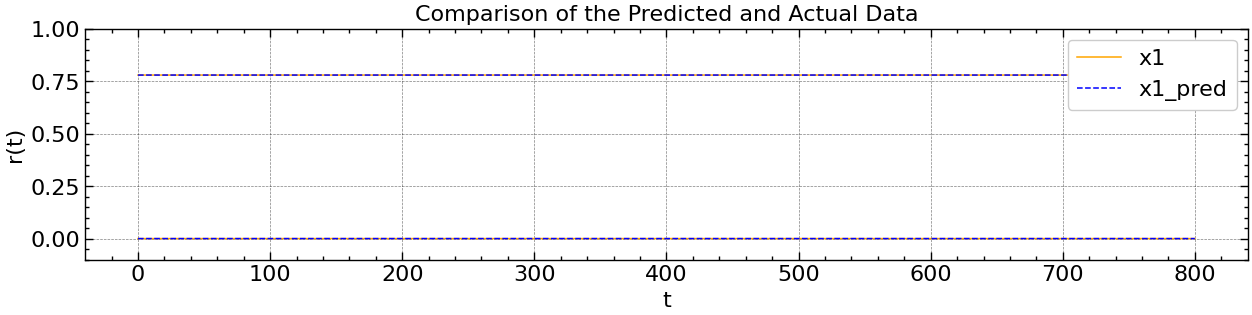

In [62]:
k1_val_test = [-0.1,-0.05,0.13,0.23]

for k1 in k1_val_test:
	x_data = solution_for_para(k1,k2)
	valid_data = x_data[-16000:]  

	print(valid_data.shape)

	predicted_data, Res_test_total = model.predict(k1,len(valid_data), valid_data, train_without_transient)
	total_var = np.var(predicted_data)
	NRMSE = np.sqrt(np.mean((valid_data[:] - predicted_data[:]) ** 2) / total_var)
	print("The NRMSE value of mu value {} :".format(k1), NRMSE)

	plot_predicted_and_actual(valid_data,predicted_data)

## 6. Eigen value analysis

In [63]:
A, W_in, W_out, W_b = model.get_weights()
alpha =1
eb = 0
Lambda = A + np.matmul(W_in, W_out)
Omega = k_b * W_b

In [64]:
import eigen_analysis as eg
epsilon_list=np.array([0.2,0.1,-0.7])
analysis_model = eg.eigenvalues(eb,alpha,Lambda,Omega,dim_reservoir)
eig_array = analysis_model.eigen_values(epsilon_list,int_guess=0.9)

[ 0.4520429   0.03048861 -0.61916448  0.65787955 -0.57388523  0.06717264
 -0.4982913  -0.30132151  0.45654821  0.39896712]
[ 0.43914626  0.03002724 -0.61326348  0.6533909  -0.56597309  0.06773578
 -0.48529881 -0.29129344  0.44410518  0.39582447]
[ 0.38238541  0.02985776 -0.61974499  0.6645691  -0.55755462  0.08138072
 -0.4201897  -0.24840195  0.40283021  0.41832897]


c:\Users\User\Desktop\Coding\Research Work\eigen_analysis.py:57: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solution = fsolve(func, initial_guess)


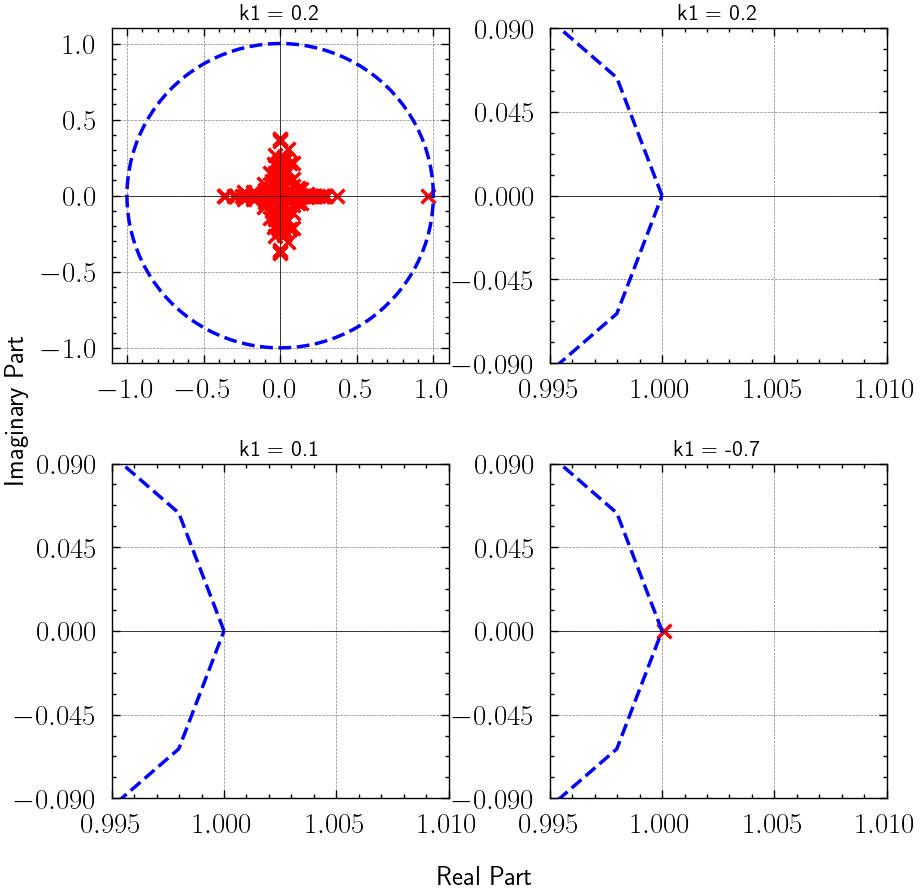

In [65]:
x_lim = [0.995, 1.01, 4]
y_lim = [-0.09, 0.09, 5]

analysis_model.Plot_eig_values(eig_array,epsilon_list,x_lim,y_lim)

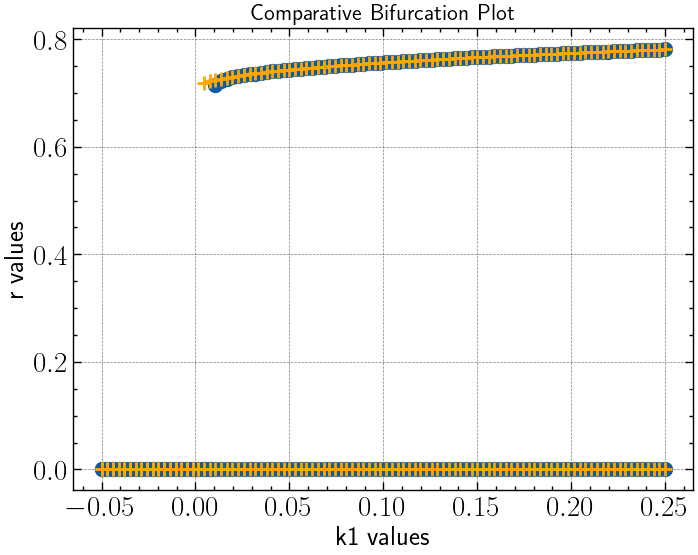

In [66]:
A, W_in, W_out, W_b = model.get_weights()
k_1_values = np.linspace(-0.05,0.25,100)
eb = 0
steps = 2000
fixed_point = []
fixed_actual_pt = []
for k1 in k_1_values:
    x_data = solution_for_para(k1,k2)
    fixed_actual_pt.append(x_data[30000])
    
    prediction = np.zeros((steps, dim_system))
    r_state = np.ones(dim_reservoir) * 0.6
    prediction[0] = np.transpose(np.dot(W_out, r_state))
    for i in range (1, steps):
        r_state = ((1- alpha)* r_state) + alpha* np.tanh(np.matmul(A, r_state) + np.matmul(W_in, prediction[i-1]) + k_b * W_b * (k1 - eb))
        prediction[i] = np.transpose(np.dot(W_out, r_state))
    fixed_point.append(prediction.T[:,1999])

k1_point_data = [[x, x] for x in k_1_values]
plt.scatter(k1_point_data,fixed_point,marker='o')
plt.scatter(k1_point_data,fixed_actual_pt,marker='+',color='orange')
plt.xlabel("k1 values")
plt.ylabel("r values")
plt.title("Comparative Bifurcation Plot")
plt.show()